In [2]:
#EE224 Pset 6
#Author: Kapil Dheeriya
#May 28, 2023
import numpy as np
import matplotlib.pyplot as plt
import scipy
import scipy.linalg as la
import math
from mpl_toolkits.axes_grid1 import AxesGrid
pi = np.pi
sq2 = np.sqrt(2)

## 1 Stochastic wavefunction evolution for open quantum systems

### Part A

i. Spontaneous decay only

In [11]:
tmax = 10 #s
dt = 0.01 #s
t = 0 
H = 0
gamma1 = 0.5 #Hz
I2 = np.identity(2)
O = np.array([[1,0],[0,0]])
A1 = np.array([[0,0],[1,0]])
e = np.array([1,0])
g = np.array([0,1])

def algo1(H, O, A1, dt, tmax, gamma1, psi0):
    t = 0
    Heff = H - 1j*0.5*gamma1*(np.transpose(A1)@A1)
    rng = np.random.default_rng()
    expectations = []
    psi = psi0
    #Compute a single trajectory
    while(t <tmax):
        expectations.append(np.vdot(psi, O@psi))
        dp = gamma1*dt*np.vdot(A1@psi, A1@psi)
        r = rng.random()
        if (r >= dp):
            #evolve psi without jump ie under Heff
            psi = (I2 - 1j*Heff*dt)@psi
            #Renormalize
            psi = (1/np.sqrt(np.vdot(psi,psi)))*psi
        else:
            #Evovlve psi with jump
            psi = A1@psi
            psi = (1/np.sqrt(np.vdot(psi,psi)))*psi
        #Update time
        t += dt
    return expectations



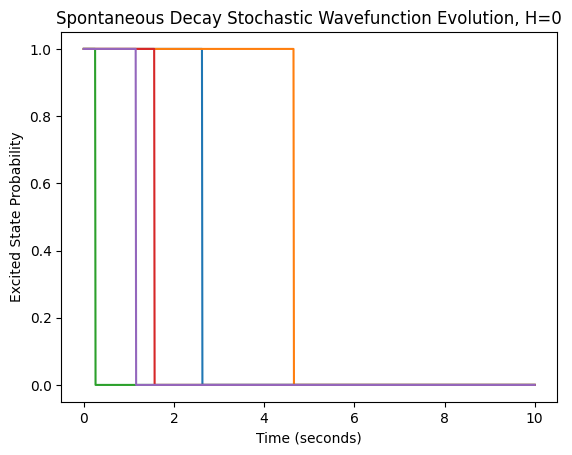

In [13]:
times = np.arange(start=0, stop=tmax+dt, step=dt)
for m in range(0,5):
    data = algo1(H, O, A1, dt, tmax, gamma1, e)
    plt.plot(times,data)
    plt.xlabel('Time (seconds)')
    plt.ylabel('Excited State Probability')
    plt.title('Spontaneous Decay Stochastic Wavefunction Evolution, H=0')

We find that under H = 0, the initial excited state remains in the excited state until a jump occurs randomly. Once the jump occurs, the excited state drops to the ground state, and the ground state then remains in the ground state forever with no chance of returning back to the excited state. Intuitively, we are seeing the excited state flip to the ground state at various random times due to spontaneous decay, which is why the probability of the excited state goes from 1 to 0.

ii. Rabi Oscillations with Spontaneous Decay

Text(0.5, 1.0, 'Spontaneous Decay Stochatic Wavefunction Evolution with Rabi Oscillation')

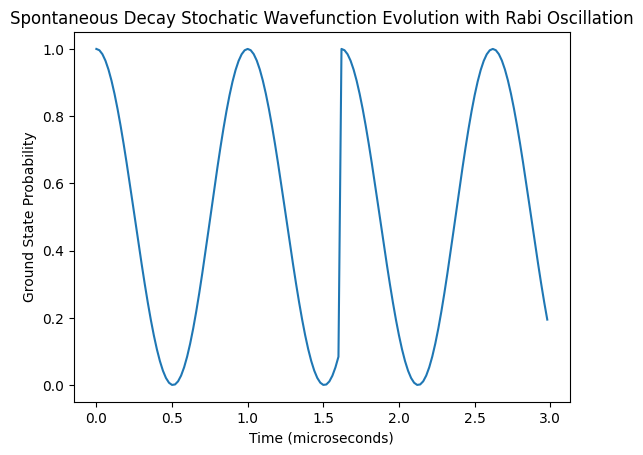

In [17]:
omega = 2*pi
Hrabi = (omega/2)*np.array([[0,1],[1,0]]) #Mhz
gamma2 = 0.04*omega
T = 3 #microseconds
dt2 = 0.02 #microseconds
O2 = np.array([[0,0],[0,1]])

times2 = np.arange(start=0, stop=T, step=dt2)
data = algo1(Hrabi, O2, A1, dt2, T, gamma2, g)
plt.plot(times2,data)
plt.xlabel('Time (microseconds)')
plt.ylabel('Ground State Probability')
plt.title('Spontaneous Decay Stochatic Wavefunction Evolution with Rabi Oscillation')

Text(0.5, 1.0, 'Spontaneous Decay Stochatic Wavefunction Evolution with Rabi Oscillation')

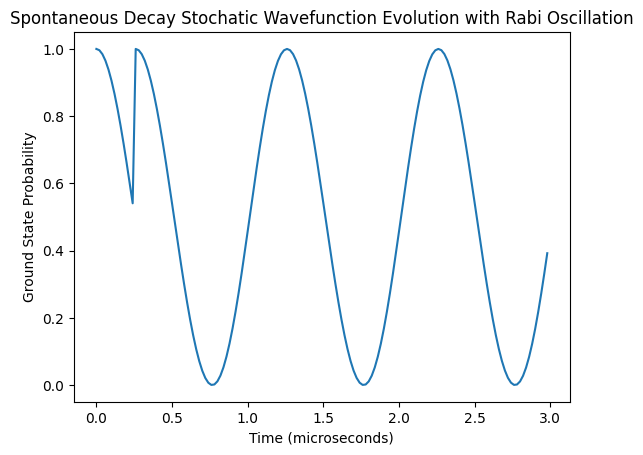

In [20]:
data = algo1(Hrabi, O2, A1, dt2, T, gamma2, g)
plt.plot(times2,data)
plt.xlabel('Time (microseconds)')
plt.ylabel('Ground State Probability')
plt.title('Spontaneous Decay Stochatic Wavefunction Evolution with Rabi Oscillation')

Here we see a standard Rabi oscillation of a qubit being disrupted by random jumps that reset the quantum state to the ground state (the |e> part of the wavefunction is flipped to |g> by the jump operator when it randomly acts on the state, and the |e> part gets projected to 0 by the jump operator). The phases of the rabi oscillations are shifted by the jumps for each trajectory, so when we average over many trajectories, we end up getting a decoherent wavefunction since each trajectory has a different phase after some time has elapsed.

### Part B/Part C

In [21]:

#Construct Monte Carlo averaging algorithm
def algo2(M, rho0, H, O, A1, dt, tmax, gamma1):
    weighted_purestate_avgs = []
    for (prob, purestate) in rho0:
        expectations = []
        for m in range(0, M):
            data = algo1(H, O, A1, dt, tmax, gamma1, purestate)
            expectations.append(data)
        weighted_purestate_avgs.append(prob*np.mean(expectations, axis=0))
    result = np.sum(weighted_purestate_avgs, axis=0)
    times = np.arange(start=0, stop=tmax+dt, step=dt)
    if len(times) != len(result):
        times = times[0:(len(times)-1)]
    return times,result

In [22]:
#Initial density matrix decomposed into its pure states and their corresponding probabilities
rho0 = zip([1], [np.array([[0,0],[0,1]])])
#Run Algorithm 2 with given parameters
montecarlo = algo2(10**3, rho0, Hrabi, O2, A1, 0.02, 20, gamma2)

rho0 = zip([1], [np.array([[0,0],[0,1]])])
#Part C: Repeat for dt = 50, 100, 200, 400 ns
montecarlo50 = algo2(10**3, rho0, Hrabi, O2, A1, 0.05, 20, gamma2)
rho0 = zip([1], [np.array([[0,0],[0,1]])])
montecarlo100 = algo2(10**3, rho0, Hrabi, O2, A1, 0.1, 20, gamma2)
rho0 = zip([1], [np.array([[0,0],[0,1]])])
montecarlo200 = algo2(10**3, rho0, Hrabi, O2, A1, 0.2, 20, gamma2)
rho0 = zip([1], [np.array([[0,0],[0,1]])])
montecarlo400 = algo2(10**3, rho0, Hrabi, O2, A1, 0.4, 20, gamma2)

C:\Users\kapil\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\matplotlib\cbook\__init__.py:1335: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


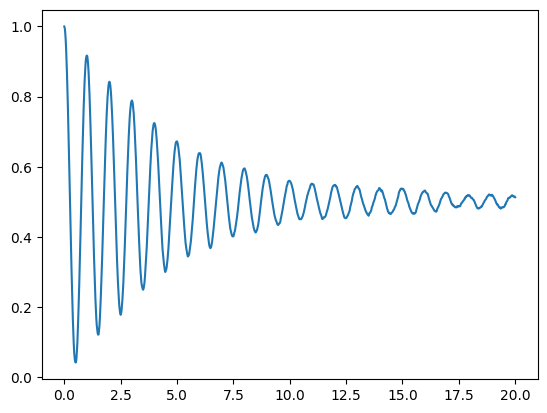

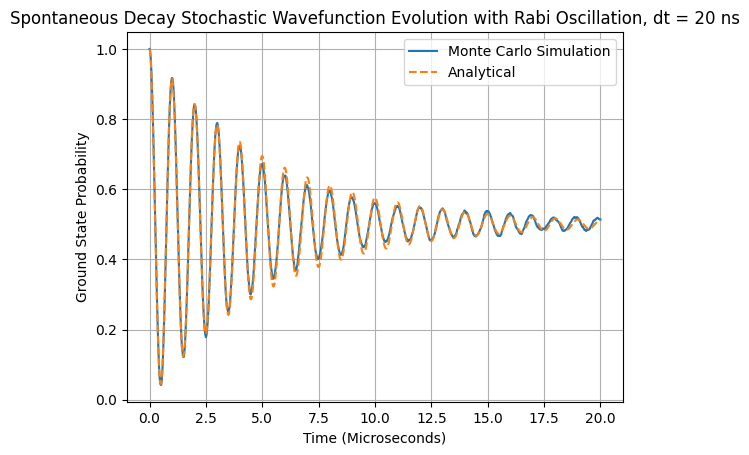

In [37]:
plt.plot(montecarlo[0], montecarlo[1])

#Analytical prediction
def pganal(gamma, omega, t):
    return .5+0.5*(np.exp(-0.75*gamma*t))*np.cos(omega*t)

ts = montecarlo[0]
def plotmc(montecarlo, gamma, omega, dt):
    fig, ax  = plt.subplots()
    ax.plot(montecarlo[0],montecarlo[1], label= 'Monte Carlo Simulation')
    ax.plot(ts, pganal(gamma, omega, ts), label = 'Analytical', linestyle = 'dashed')
    ax.set(xlabel='Time (Microseconds)', ylabel='Ground State Probability',
        title=f'Spontaneous Decay Stochastic Wavefunction Evolution with Rabi Oscillation, dt = {dt} ns')
    ax.grid()
    ax.legend()

plotmc(montecarlo, gamma2, omega, 20)

The plot clearly shows that our monte carlo simulation matches up with the analytical prediction.

### Part C

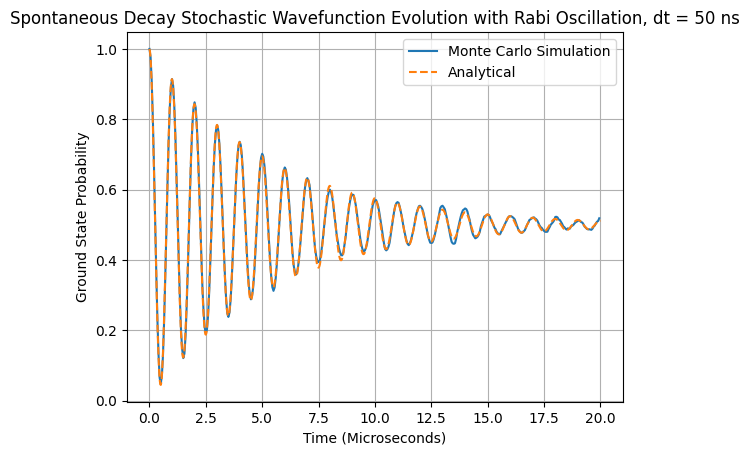

In [38]:
plotmc(montecarlo50, gamma2, omega, 50)

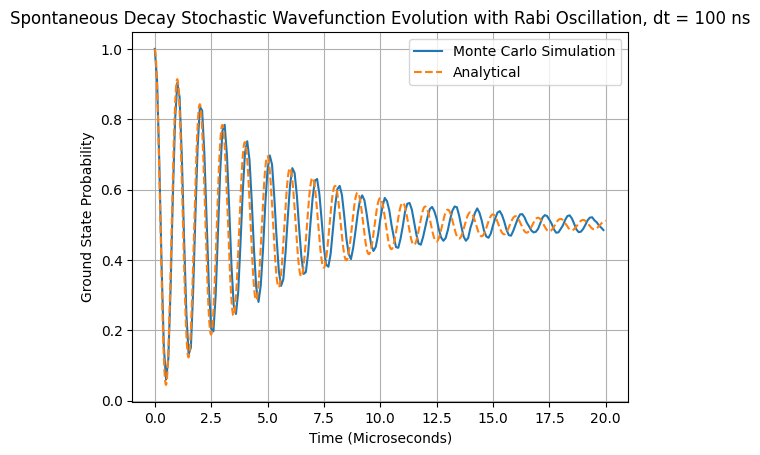

In [39]:

plotmc(montecarlo100,gamma2, omega,100)

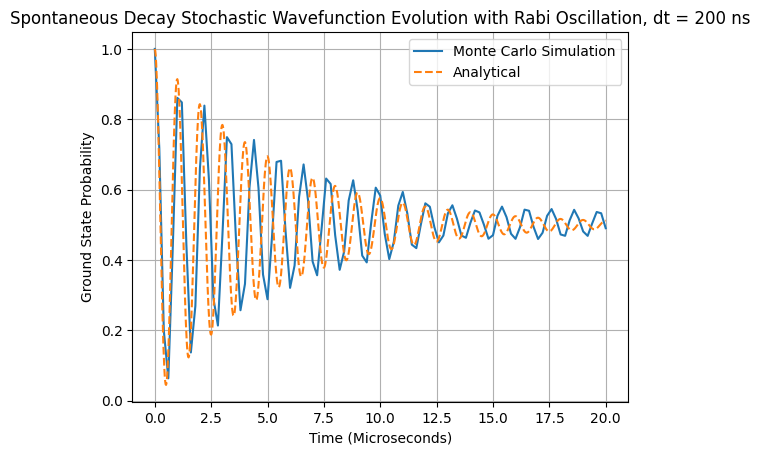

In [40]:
plotmc(montecarlo200,gamma2, omega,200)

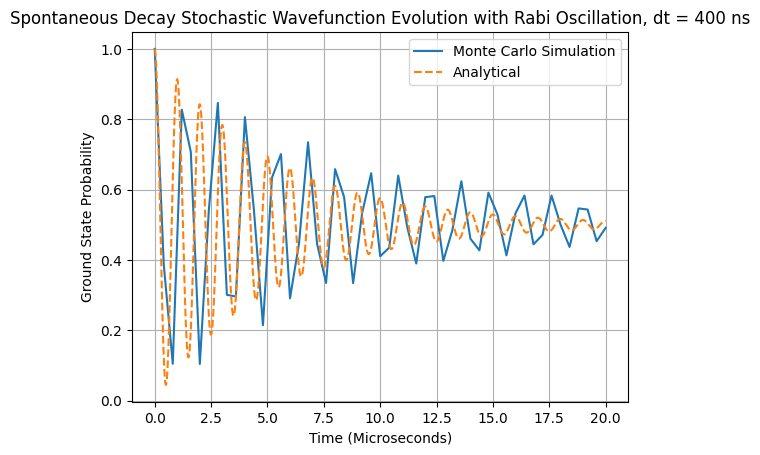

In [41]:
plotmc(montecarlo400,gamma2, omega,400)

We see that the simulated results break down and slowly become out of phase with the analytical prediction for large timesteps.

Part D

C:\Users\kapil\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\matplotlib\cbook\__init__.py:1335: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


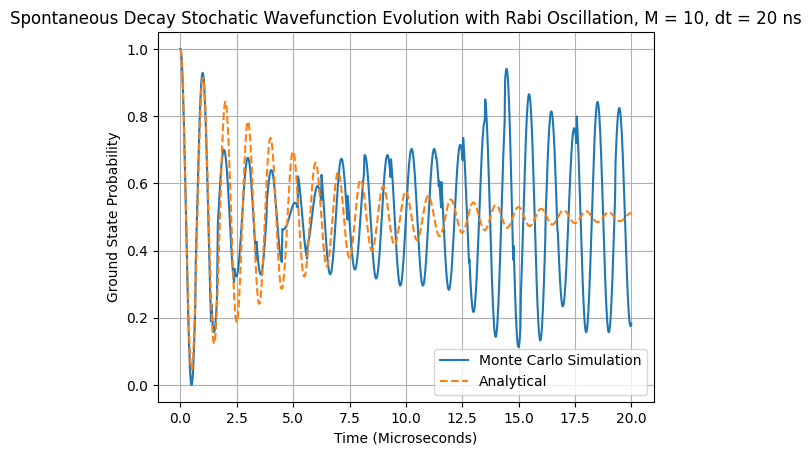

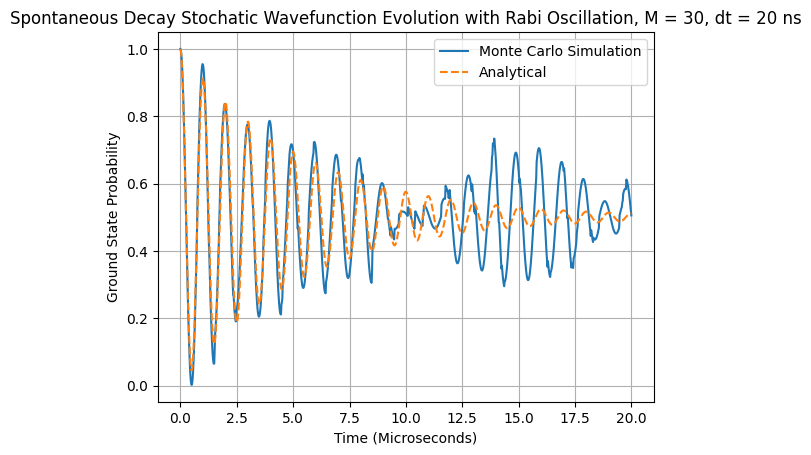

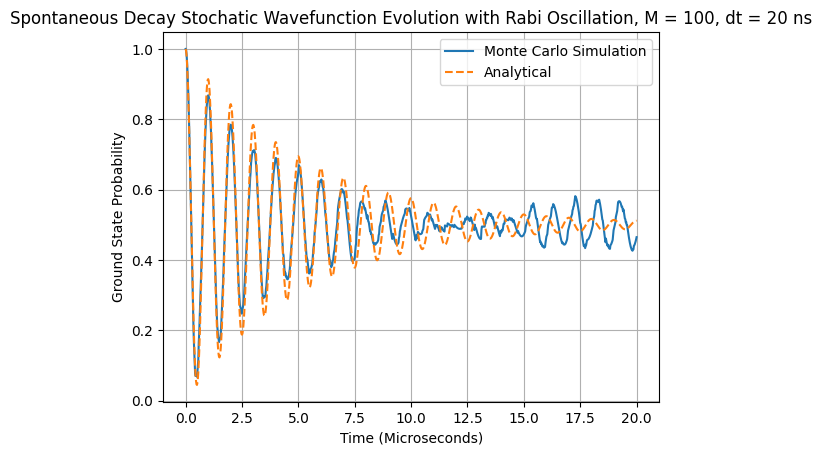

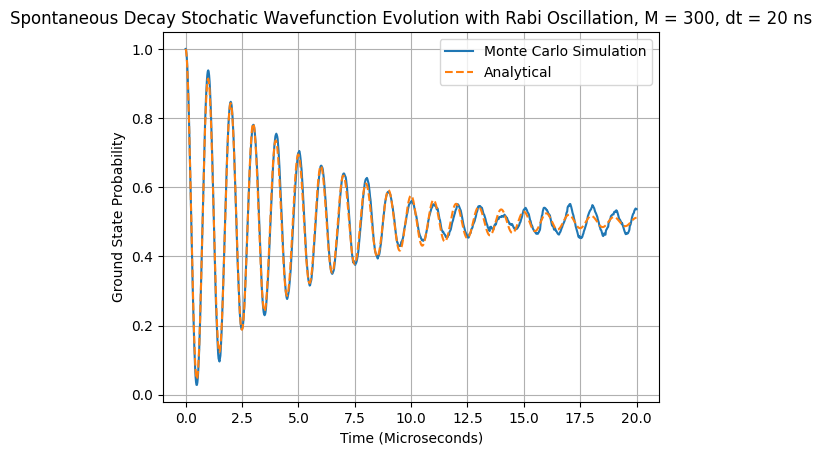

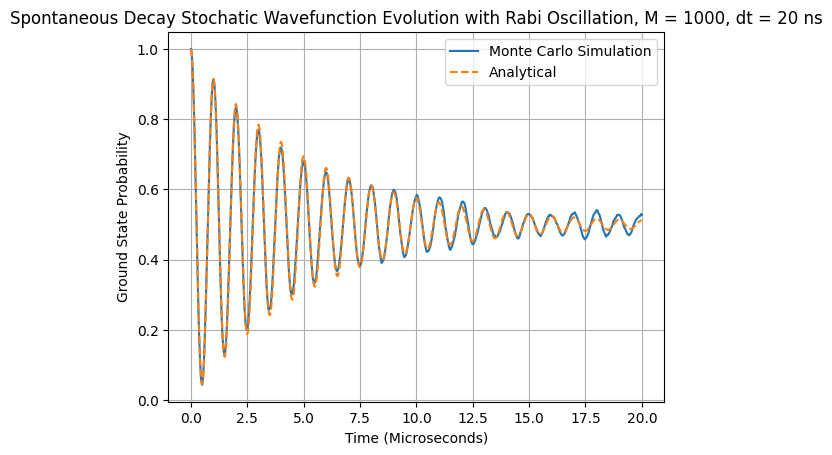

In [28]:
mvals = [10, 30, 100, 300, 1000]
for m in mvals:
    rho0 = zip([1], [np.array([[0,0],[0,1]])])
    montecarlo = algo2(m, rho0, Hrabi, O2, A1, 0.02, 20, gamma2)
    fig, ax  = plt.subplots()
    ax.plot(montecarlo[0],montecarlo[1], label= 'Monte Carlo Simulation')
    ax.plot(montecarlo[0], pganal(gamma2, omega, montecarlo[0]), label = 'Analytical', linestyle = 'dashed')
    ax.set(xlabel='Time (Microseconds)', ylabel='Ground State Probability',
        title=f'Spontaneous Decay Stochatic Wavefunction Evolution with Rabi Oscillation, M = {m}, dt = 20 ns')
    ax.grid()
    ax.legend()

We can clearly see that the performance of our monte carlo simulation suffers for smaller iteration numbers, whereas large iteration numbers on the order of 300 converge to the analytical expression. Especially for M=10 and M=30, it looks as though the stochastic wavefunction evolution does not converge to P = 0.5 and instead continues to oscillate wildly.

Part E

C:\Users\kapil\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\matplotlib\cbook\__init__.py:1335: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


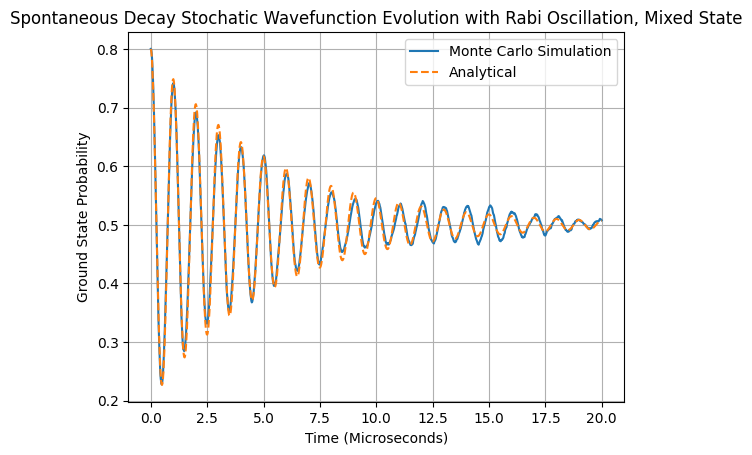

In [33]:
rhomixed = zip([0.8, 0.2], [np.array([[0,0],[0,1]]), np.array([[1,0],[0,0]])])
#Run Algorithm 2 with given parameters and mixed state
mcmixed = algo2(10**3, rhomixed, Hrabi, O2, A1, 0.02, 20, gamma2)

#Construct new analytical function for mixed state
def pganalmixed(gamma, omega, t):
    return .5 + (0.8-0.2)*0.5*(np.exp(-0.75*gamma*t))*np.cos(omega*t)

fig, ax  = plt.subplots()
ax.plot(mcmixed[0],mcmixed[1], label= 'Monte Carlo Simulation')
ax.plot(mcmixed[0], pganalmixed(gamma2, omega, mcmixed[0]), label = 'Analytical', linestyle = 'dashed')
ax.set(xlabel='Time (Microseconds)', ylabel='Ground State Probability',
    title=f'Spontaneous Decay Stochatic Wavefunction Evolution with Rabi Oscillation, Mixed State')
ax.grid()
ax.legend()


Indeed we see the state preparation error from the reduction in contrast of the Rabi oscillation signal.

Part F

In [37]:
#Construct modified Monte Carlo averaging algorithms for three jump operators
def algo1modified(H, O, A1, A2, A3, dt, tmax, gamma1, gamma2, gamma3, psi0):
    t = 0
    Heff = H - 1j*0.5*gamma1*(np.transpose(A1)@A1)
    rng = np.random.default_rng()
    expectations = []
    psi = psi0
    #Compute a single trajectory
    while(t <tmax):
        expectations.append(np.vdot(psi, O@psi))
        dp1 = gamma1*dt*np.vdot(A1@psi, A1@psi)
        dp2 = gamma2*dt*np.vdot(A2@psi, A2@psi)
        dp3 = gamma3*dt*np.vdot(A3@psi, A3@psi)
        r = rng.random()
        if (r >= (dp1+dp2+dp3)):
            #evolve psi without jump ie under Heff
            psi = (I2 + 1j*Heff*dt)@psi
            #Renormalize
            psi = (1/np.sqrt(np.vdot(psi,psi)))*psi
        else:
            #Evovlve psi with jump
            if (r<dp1):
                psi = A1@psi
                psi = (1/np.sqrt(np.vdot(psi,psi)))*psi
            elif (r<(dp1+dp2)):
                psi = A2@psi
                psi = (1/np.sqrt(np.vdot(psi,psi)))*psi
            else: 
                psi = A3@psi
                psi = (1/np.sqrt(np.vdot(psi,psi)))*psi
        #Update time
        t += dt
    return expectations

def algo2modified(M, rho0, H, O, A1, A2, A3, dt, tmax, gamma1, gamma2, gamma3):
    weighted_purestate_avgs = []
    for (prob, purestate) in rho0:
        expectations = []
        for m in range(0, M):
            data = algo1modified(H, O, A1, A2, A3, dt, tmax, gamma1, gamma2, gamma3, purestate)
            expectations.append(data)
        weighted_purestate_avgs.append(prob*np.mean(expectations, axis=0))
    result = np.sum(weighted_purestate_avgs, axis=0)
    times = np.arange(start=0, stop=tmax+dt, step=dt)
    if len(times) != len(result):
        times = times[0:(len(times)-1)]
    return times,result

In [38]:
#Initial density matrix decomposed into its pure states and their corresponding probabilities
rho0 = zip([1], [np.array([[0,0],[0,1]])])
A2 = np.array([[0,0],[0,1]])
A3 = np.array([[1,0],[0,0]])

#Run Algorithm 2 with given parameters
mc1 = algo2modified(10**3, rho0, Hrabi, O2, A1,A2,A3, 0.02, 20, 0.04*omega, 0.02*omega, 0.02*omega)

C:\Users\kapil\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\matplotlib\cbook\__init__.py:1335: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


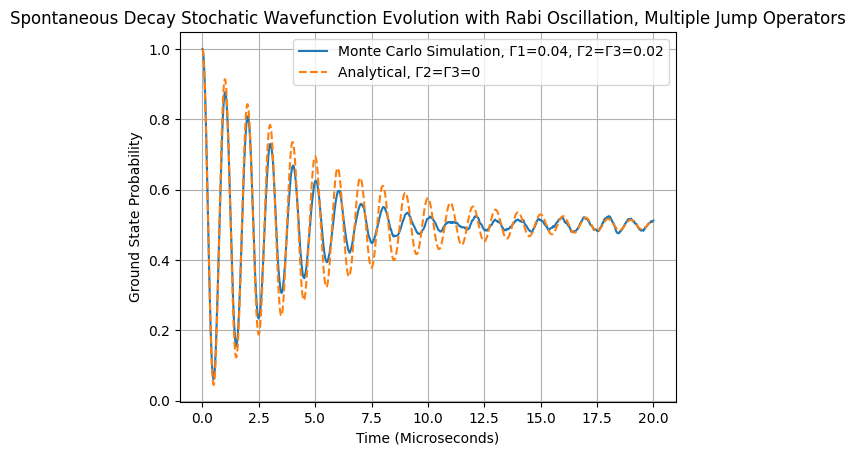

In [42]:
fig, ax  = plt.subplots()
ax.plot(mc1[0],mc1[1], label= 'Monte Carlo Simulation, Γ1=0.04, Γ2=Γ3=0.02')
ax.plot(mc1[0], pganal(gamma2, omega, mc1[0]), label = 'Analytical, Γ2=Γ3=0', linestyle = 'dashed')
ax.set(xlabel='Time (Microseconds)', ylabel='Ground State Probability',
    title=f'Spontaneous Decay Stochatic Wavefunction Evolution with Rabi Oscillation, Multiple Jump Operators')
ax.grid()
ax.legend()

We can see that the oscillation decay is more rapid than the previous case of Γ2=Γ3=0.

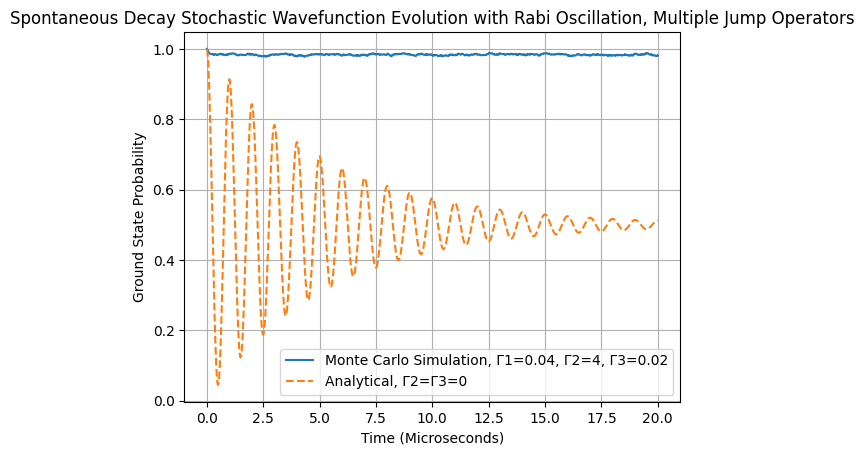

In [46]:
#Strong dephasing, quantum zeno effect
rho0 = zip([1], [np.array([[0,0],[0,1]])])
mc2 = algo2modified(10**3, rho0, Hrabi, O2, A1,A2,A3, 0.02, 20, 0.04*omega, 4*omega, 0.02*omega)
fig, ax  = plt.subplots()
ax.plot(mc2[0],mc2[1], label= 'Monte Carlo Simulation, Γ1=0.04, Γ2=4, Γ3=0.02')
ax.plot(mc1[0], pganal(gamma2, omega, mc1[0]), label = 'Analytical, Γ2=Γ3=0', linestyle = 'dashed')
ax.set(xlabel='Time (Microseconds)', ylabel='Ground State Probability',
    title=f'Spontaneous Decay Stochastic Wavefunction Evolution with Rabi Oscillation, Multiple Jump Operators')
ax.grid()
ax.legend()

Interesting demonstration of the quantum zeno effect with extremely strong dephasing causing frequent projections to the ground state.

# 2 Quantum State Tomography

Compute/display rho target:

In [3]:

def heatmap2d(arr: np.ndarray):
    # define axes grid
    fig = plt.figure(frameon=False,figsize=(12, 8))
    fig.subplots_adjust(top=0.95)
    grid = AxesGrid(
        fig, 111, 
        nrows_ncols=(1, 2),
        axes_pad=0.5,
        cbar_mode='each',
        cbar_location='right',
        cbar_pad=0.1
    )   
    # plot 
    real_image = grid[0].imshow(np.real(arr), cmap='plasma')
    grid[0].set_title("Real Part of matrix, $\Re{(M)}$", fontsize=20)
    imag_image = grid[1].imshow(np.imag(arr), cmap='plasma')
    grid[1].set_title("Imaginary Part of matrix, $\Im{(M)}$", fontsize=20)
    cbar = grid.cbar_axes[0].colorbar(real_image)
    cbar = grid.cbar_axes[1].colorbar(imag_image)
    plt.show()
    

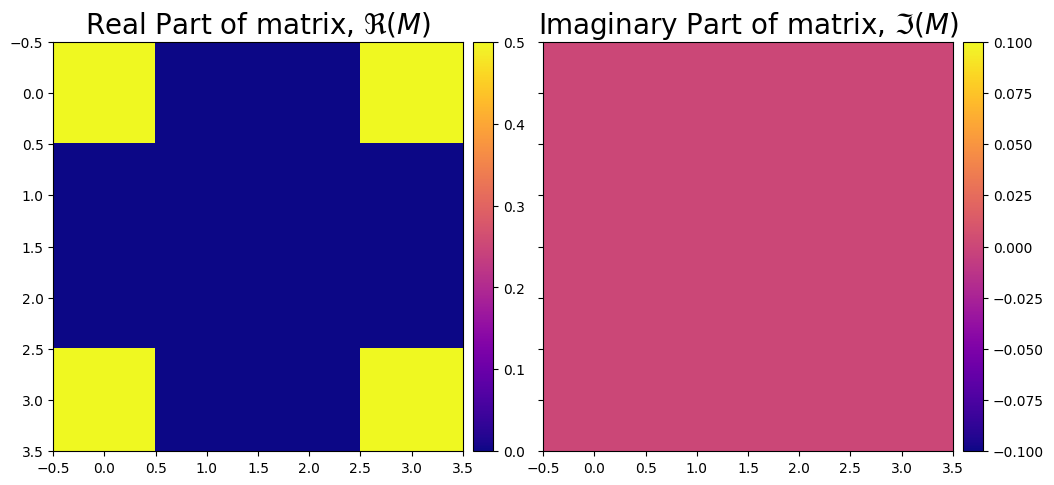

In [6]:
rhotarget = 0.5*np.outer(np.array([1,0,0,1]),np.array([1,0,0,1]))
heatmap2d(rhotarget)

Compute rho experimental

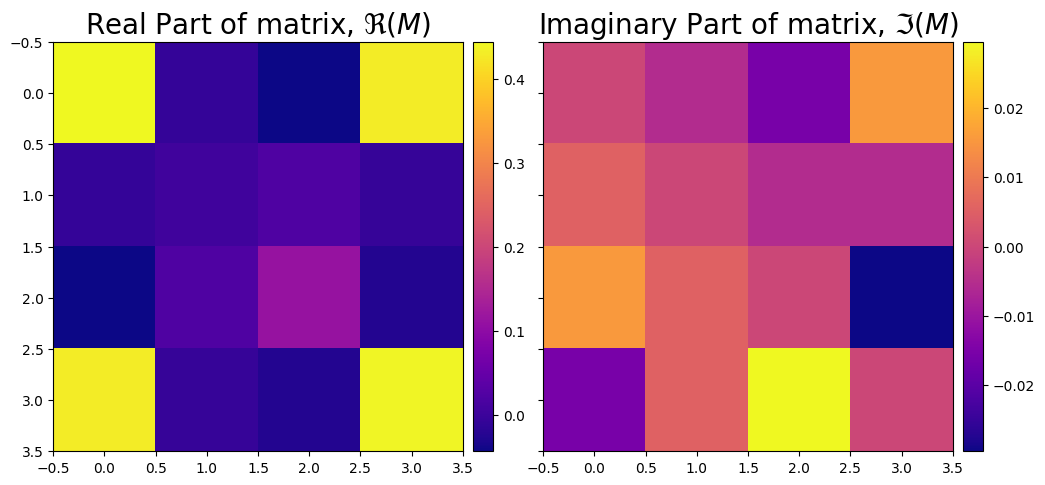

In [29]:
#Coefficients of each of our basis operators
coeffs = np.array([[1, -.068, .070, .112],
                   [-.100, .906, -.042, -.074],
                   [.042, -.020, -.816, .020],
                   [-.102, .034, -.048, .766]])

pauli = [I2, np.array([[0,1],[1,0]]), np.array([[0,-1j],[1j,0]]), 
         np.array([[1,0],[0,-1]])]

rhoexp = np.zeros((4,4))

for i in range(0,4):
    for j in range(0,4):
        rhoexp = rhoexp + 0.25*coeffs[i][j]*np.kron(pauli[i], pauli[j])

heatmap2d(rhoexp)

Compute Fidelity

In [30]:
fidelity = np.trace(rhotarget@rhoexp)
fidelity

(0.872+0j)

So F = 0.872

In [46]:
1j*np.outer(np.array([1,1j]), np.array([1,-1j]))

array([[ 0.+1.j,  1.+0.j],
       [-1.+0.j,  0.+1.j]])